# 8장 Recommendations

## Splitting into training and testing

### 영화 평점에 대한 데이터를 다운로드
http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [1]:
%matplotlib inline

In [3]:
import numpy as np
from scipy import sparse
from os import path
data = np.loadtxt('data/ml-100k/u.data')

In [4]:
def load():
    '''Load ML-100k data

    Returns the review matrix as a numpy array'''
    import numpy as np
    from scipy import sparse
    from os import path

    if not path.exists('data/ml-100k/u.data'):
        raise IOError("Data has not been downloaded.\nTry the following:\n\n\tcd data\n\t./download.sh")

    # The input is in the form of a CSC sparse matrix, so it's a natural fit to
    # load the data, but we then convert to a more traditional array before
    # returning
    # user id | item id | rating | timestamp
    data = np.loadtxt('data/ml-100k/u.data')
    ij = data[:, :2]
    ij -= 1  # original data is in 1-based system
    values = data[:, 2]
    # 희소 행렬로 변환 https://ko.wikipedia.org/wiki/%ED%9D%AC%EC%86%8C%ED%96%89%EB%A0%AC
    reviews = sparse.csc_matrix((values, ij.T)).astype(float)
    return reviews.toarray()

In [5]:
data

array([[  1.96000000e+02,   2.42000000e+02,   3.00000000e+00,
          8.81250949e+08],
       [  1.86000000e+02,   3.02000000e+02,   3.00000000e+00,
          8.91717742e+08],
       [  2.20000000e+01,   3.77000000e+02,   1.00000000e+00,
          8.78887116e+08],
       ..., 
       [  2.76000000e+02,   1.09000000e+03,   1.00000000e+00,
          8.74795795e+08],
       [  1.30000000e+01,   2.25000000e+02,   2.00000000e+00,
          8.82399156e+08],
       [  1.20000000e+01,   2.03000000e+02,   3.00000000e+00,
          8.79959583e+08]])

In [6]:
data[:,:2]

array([[  196.,   242.],
       [  186.,   302.],
       [   22.,   377.],
       ..., 
       [  276.,  1090.],
       [   13.,   225.],
       [   12.,   203.]])

In [7]:
data[:,:2] - 1

array([[  195.,   241.],
       [  185.,   301.],
       [   21.,   376.],
       ..., 
       [  275.,  1089.],
       [   12.,   224.],
       [   11.,   202.]])

In [11]:
data[:, 2]

array([ 3.,  3.,  1., ...,  1.,  2.,  3.])

In [115]:
sparse.csc_matrix((data[:, 2], (data[:,:2] - 1).T)).astype(float).toarray()

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [60]:
import numpy as np # NOT IN BOOK
from matplotlib import pyplot as plt # NOT IN BOOK

reviews = load()
# nonzero와 동일, 평점이 등록되지 않은 항목을 제거하기 위함.
U,M = np.where(reviews)

In [61]:
import random
# // 는 floor division, 소수점 이하를 버린 integer 반환
test_idxs = np.array(random.sample(range(len(U)), len(U)//10))

# 학습용 데이터는 테스트용으로 선정된 데이터를 제거
train = reviews.copy()
train[U[test_idxs], M[test_idxs]] = 0

# reviews와 동일한 모양과 유형을 가진 0의 배열 생성
test = np.zeros_like(reviews)
# 테스트용 데이터 입력
test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]

In [118]:
np.zeros_like(reviews)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Normalizing the training data

In [58]:
class NormalizePositive(object):
    def __init__(self, axis=0):
        self.axis = axis

    def fit(self, features, y=None):
        if self.axis == 1:
            features = features.T
        #  count features that are greater than zero in axis 0:
        binary = (features > 0)
        
        
        count0 = binary.sum(axis=0)

        # to avoid division by zero, set zero counts to one:
        count0[count0 == 0] = 1.

        # computing the mean is easy:
        self.mean = features.sum(axis=0)/count0

        # only consider differences where binary is True:
        diff = (features - self.mean) * binary
        diff **= 2
        # regularize the estimate of std by adding 0.1
        self.std = np.sqrt(0.1 + diff.sum(axis=0)/count0)
        return self


    def transform(self, features):
        if self.axis == 1:
            features = features.T
        binary = (features > 0)
        features = features - self.mean
        features /= self.std
        features *= binary
        if self.axis == 1:
            features = features.T
        return features

    def inverse_transform(self, features, copy=True):
        if copy:
            features = features.copy()
        if self.axis == 1:
            features = features.T
        features *= self.std
        features += self.mean
        if self.axis == 1:
            features = features.T
        return features

    def fit_transform(self, features):
        return self.fit(features).transform(features)

In [50]:
test1= np.array([[1,2,3,4,5,6,0], [8,7,6,5,4,3,2], [0,0,0,0,0,0,0]])
test2 = (test1 > 3)

In [51]:
test2

array([[False, False, False,  True,  True,  True, False],
       [ True,  True,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False]], dtype=bool)

In [54]:
test_count = test2.sum(axis=0)
test_count

array([1, 1, 1, 2, 2, 1, 0])

In [55]:
test_count

array([1, 1, 1, 2, 2, 1, 0])

In [56]:
test_count[test_count==0] = 1.

In [57]:
test_count

array([1, 1, 1, 2, 2, 1, 1])

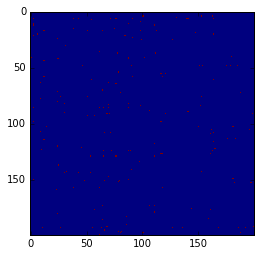

In [69]:
norm = NormalizePositive(axis=1)
binary = (train > 0)
train = norm.fit_transform(train)
# plot just 200x200 area for space reasons
plt.imshow(binary[:200, :200], interpolation='nearest')

## A neighborhood approach to recommendations

In [73]:
from scipy.spatial import distance
# compute all pair-wise distances:
# https://ko.wikipedia.org/wiki/상관분석
dists = distance.pdist(binary, 'correlation')

In [74]:
# Convert to square form, so that dists[i,j]
# is distance between binary[i] and binary[j]:
dists = distance.squareform(dists)
neighbors = dists.argsort(axis=1)

In [70]:
binary

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]], dtype=bool)

In [77]:
dists

array([[ 0.        ,  1.00223451,  1.00316101, ...,  1.00223451,
         1.00223451,  1.00592253],
       [ 1.00223451,  0.        ,  1.00084154, ...,  1.00059488,
         1.00059488,  1.00157673],
       [ 1.00316101,  1.00084154,  0.        , ...,  1.00084154,
         1.00084154,  1.0022305 ],
       ..., 
       [ 1.00223451,  1.00059488,  1.00084154, ...,  0.        ,
         1.00059488,  1.00157673],
       [ 1.00223451,  1.00059488,  1.00084154, ...,  1.00059488,
         0.        ,  1.00157673],
       [ 1.00592253,  1.00157673,  1.0022305 , ...,  1.00157673,
         1.00157673,  0.        ]])

In [123]:
neighbors

array([[  0, 915, 737, ..., 723, 350, 862],
       [  1, 700, 130, ..., 814, 845, 404],
       [  2, 316, 862, ..., 405, 931, 404],
       ..., 
       [940,  65, 816, ..., 315, 425, 404],
       [941, 262, 453, ..., 564, 433, 348],
       [942, 773, 681, ..., 488, 862, 781]])

In [124]:
# We are going to fill this matrix with results
filled = train.copy()

In [125]:
for u in range(filled.shape[0]):
    # n_u is neighbors of user
    n_u = neighbors[u, 1:]
    for m in range(filled.shape[1]):
        # get relevant reviews in order!
        revs = [train[neigh, m]
                   for neigh in n_u
                        if binary[neigh, m]]
        if len(revs):
            # n is the number of reviews for this movie
            n = len(revs)
            # take half of the reviews plus one into consideration:
            n //= 2
            n += 1
            revs = revs[:n]
            filled[u,m] = np.mean(revs)

In [126]:
predicted = norm.inverse_transform(filled)
from sklearn import metrics
# regression score
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (binary neighbors): {:.1%}'.format(r2))

R2 score (binary neighbors): 31.5%


In [127]:
reviews = reviews.T
predicted = norm.inverse_transform(filled)

# use same code as before 
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (binary movie neighbors): {:.1%}'.format(r2))

R2 score (binary movie neighbors): 31.5%


### Classification은 적합하지 않음
#### 오차에 대한 문제
#### 중간값에 대한 문제


## A regression approach to recommendations

In [128]:
from sklearn.linear_model import ElasticNetCV # NOT IN BOOK

reg = ElasticNetCV(alphas=[
                       0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])
filled = train.copy()
# iterate over all users:
for u in range(train.shape[0]):
    curtrain = np.delete(train, u, axis=0)
    bu = binary[u]
    reg.fit(curtrain[:,bu].T, train[u, bu])
    filled[u, ~bu] = reg.predict(curtrain[:,~bu].T)
predicted = norm.inverse_transform(filled)
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (user regression): {:.1%}'.format(r2))

R2 score (user regression): 28.0%


## Combining multiple methods

In [32]:
import load_ml100k
import regression
import corrneighbours
from sklearn import linear_model, metrics
import norm

In [33]:
def predict(train):
    tr_train,tr_test = load_ml100k.get_train_test(train, random_state=34)
    tr_predicted0 = regression.predict(tr_train)
    tr_predicted1 = regression.predict(tr_train.T).T
    tr_predicted2 = corrneighbours.predict(tr_train)
    tr_predicted3 = corrneighbours.predict(tr_train.T).T
    tr_predicted4 = norm.predict(tr_train)
    tr_predicted5 = norm.predict(tr_train.T).T
    stack_tr = np.array([
        tr_predicted0[tr_test > 0],
        tr_predicted1[tr_test > 0],
        tr_predicted2[tr_test > 0],
        tr_predicted3[tr_test > 0],
        tr_predicted4[tr_test > 0],
        tr_predicted5[tr_test > 0],
        ]).T

    lr = linear_model.LinearRegression()
    lr.fit(stack_tr, tr_test[tr_test > 0])

    stack_te = np.array([
        tr_predicted0.ravel(),
        tr_predicted1.ravel(),
        tr_predicted2.ravel(),
        tr_predicted3.ravel(),
        tr_predicted4.ravel(),
        tr_predicted5.ravel(),
        ]).T

    return lr.predict(stack_te).reshape(train.shape)

In [34]:
train,test = load_ml100k.get_train_test(random_state=12)
predicted = predict(train)
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 stacked: {:.2%}'.format(r2))

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


R2 stacked: 32.98%


/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Basket analysis

## Analyzing supermarket shopping baskets

In [35]:
# SHOPPING BASKET ANALYSIS
# This is the slow version of the code, which will take a long time to
# complete.


from collections import defaultdict
from itertools import chain

# File is downloaded as a compressed file
import gzip
# file format is a line per transaction
# of the form '12 34 342 5...'
dataset = [[int(tok) for tok in line.strip().split()]
       for line in gzip.open('data/retail.dat.gz')]
dataset = [set(d) for d in dataset]
# count how often each product was purchased:
counts = defaultdict(int)
for elem in chain(*dataset):
    counts[elem] += 1

In [36]:
dataset

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29},
 {30, 31, 32},
 {33, 34, 35},
 {36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46},
 {38, 39, 47, 48},
 {38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58},
 {32, 41, 59, 60, 61, 62},
 {3, 39, 48},
 {63, 64, 65, 66, 67, 68},
 {32, 69},
 {48, 70, 71, 72},
 {39, 73, 74, 75, 76, 77, 78, 79},
 {36, 38, 39, 41, 48, 79, 80, 81},
 {82, 83, 84},
 {41, 85, 86, 87, 88},
 {39, 48, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101},
 {36, 38, 39, 48, 89},
 {39, 41, 102, 103, 104, 105, 106, 107, 108},
 {38, 39, 41, 109, 110},
 {39, 111, 112, 113, 114, 115, 116, 117, 118},
 {119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133},
 {48, 134, 135, 136},
 {39, 48, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149},
 {39, 150, 151, 152},
 {38, 39, 56, 153, 154, 155},
 {48, 156, 157, 158, 159, 160},
 {39, 

In [37]:
counts

defaultdict(int,
            {0: 177,
             1: 266,
             2: 549,
             3: 8,
             4: 19,
             5: 295,
             6: 151,
             7: 100,
             8: 19,
             9: 1372,
             10: 712,
             11: 711,
             12: 409,
             13: 15,
             14: 19,
             15: 345,
             16: 124,
             17: 58,
             18: 860,
             19: 1005,
             20: 5,
             21: 5,
             22: 200,
             23: 758,
             24: 90,
             25: 83,
             26: 143,
             27: 157,
             28: 7,
             29: 8,
             30: 540,
             31: 920,
             32: 15167,
             33: 37,
             34: 14,
             35: 78,
             36: 2936,
             37: 1074,
             38: 15596,
             39: 50675,
             40: 211,
             41: 14945,
             42: 101,
             43: 219,
             44: 196,
           

In [39]:
minsupport = 80
valid = set(k for k,v in counts.items() if (v >= minsupport))
itemsets = [frozenset([v]) for v in valid]

In [40]:
valid

{0,
 1,
 2,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 15,
 16,
 18,
 19,
 22,
 23,
 24,
 25,
 26,
 27,
 30,
 31,
 32,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 16430,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 75,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 91,
 93,
 94,
 95,
 96,
 97,
 98,
 10939,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 110,
 111,
 116,
 117,
 120,
 123,
 124,
 8317,
 126,
 127,
 128,
 129,
 9579,
 133,
 136,
 141,
 147,
 150,
 151,
 152,
 153,
 155,
 156,
 159,
 161,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 173,
 174,
 175,
 176,
 178,
 179,
 184,
 185,
 186,
 189,
 192,
 193,
 195,
 197,
 198,
 199,
 200,
 201,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 211,
 213,
 215,
 218,
 8411,
 220,
 222,
 225,
 226,
 227,
 228,
 229,
 232,
 233,
 234,
 235,
 236,
 237,
 242,
 243,
 244,
 246,
 248,
 249,
 250,
 251,
 254,
 255,
 256,
 258,
 259,
 260,
 261,
 262,
 264,
 2

In [41]:
itemsets

[frozenset({0}),
 frozenset({1}),
 frozenset({2}),
 frozenset({5}),
 frozenset({6}),
 frozenset({7}),
 frozenset({9}),
 frozenset({10}),
 frozenset({11}),
 frozenset({12}),
 frozenset({15}),
 frozenset({16}),
 frozenset({18}),
 frozenset({19}),
 frozenset({22}),
 frozenset({23}),
 frozenset({24}),
 frozenset({25}),
 frozenset({26}),
 frozenset({27}),
 frozenset({30}),
 frozenset({31}),
 frozenset({32}),
 frozenset({36}),
 frozenset({37}),
 frozenset({38}),
 frozenset({39}),
 frozenset({40}),
 frozenset({41}),
 frozenset({42}),
 frozenset({43}),
 frozenset({44}),
 frozenset({45}),
 frozenset({16430}),
 frozenset({47}),
 frozenset({48}),
 frozenset({49}),
 frozenset({50}),
 frozenset({51}),
 frozenset({52}),
 frozenset({53}),
 frozenset({54}),
 frozenset({55}),
 frozenset({56}),
 frozenset({58}),
 frozenset({59}),
 frozenset({60}),
 frozenset({61}),
 frozenset({62}),
 frozenset({64}),
 frozenset({65}),
 frozenset({66}),
 frozenset({67}),
 frozenset({68}),
 frozenset({69}),
 frozenset({70

#### 너무 느려서 사용할 수가 없음 (7시간을 돌렸으나 결과가...)

In [44]:
freqsets = []
for i in range(16):
    nextsets = []
    tested = set()
    for it in itemsets:
        for v in valid:
            if v not in it:
                # Create a new candidate set by adding v to it
                c = (it | frozenset([v]))
                # check If we have tested it already
                if c in tested:
                    continue
                tested.add(c)

                # Count support by looping over dataset
                # This step is slow.
                # Check `apriori.py` for a better implementation.
                support_c = sum(1 for d in dataset if d.issuperset(c))
                if support_c > minsupport:
                    nextsets.append(c)
    freqsets.extend(nextsets)
    itemsets = nextsets
    if not len(itemsets):
        break
print("Finished!")

KeyboardInterrupt: 

#### apriori.py

In [47]:
from collections import namedtuple


def apriori(dataset, minsupport, maxsize):
    '''
    freqsets, support = apriori(dataset, minsupport, maxsize)

    Parameters
    ----------
    dataset : sequence of sequences
        input dataset
    minsupport : int
        Minimal support for frequent items
    maxsize : int
        Maximal size of frequent items to return

    Returns
    -------
    freqsets : sequence of sequences
    support : dictionary
        This associates each itemset (represented as a frozenset) with a float
        (the support of that itemset)
    '''
    from collections import defaultdict

    baskets = defaultdict(list)
    pointers = defaultdict(list)

    for i, ds in enumerate(dataset):
        for ell in ds:
            pointers[ell].append(i)
            baskets[frozenset([ell])].append(i)

    # Convert pointer items to frozensets to speed up operations later
    new_pointers = dict()
    for k in pointers:
        if len(pointers[k]) >= minsupport:
            new_pointers[k] = frozenset(pointers[k])
    pointers = new_pointers
    for k in baskets:
        baskets[k] = frozenset(baskets[k])


    # Valid are all elements whose support is >= minsupport
    valid = set()
    for el, c in baskets.items():
        if len(c) >= minsupport:
            valid.update(el)

    # Itemsets at first iteration are simply all singleton with valid elements:
    itemsets = [frozenset([v]) for v in valid]
    freqsets = []
    for i in range(maxsize - 1):
        print("At iteration {}, number of frequent baskets: {}".format(
            i, len(itemsets)))
        newsets = []
        for it in itemsets:
            ccounts = baskets[it]

            for v, pv in pointers.items():
                if v not in it:
                    csup = (ccounts & pv)
                    if len(csup) >= minsupport:
                        new = frozenset(it | frozenset([v]))
                        if new not in baskets:
                            newsets.append(new)
                            baskets[new] = csup
        freqsets.extend(itemsets)
        itemsets = newsets
        if not len(itemsets):
            break
    support = {}
    for k in baskets:
        support[k] = float(len(baskets[k]))
    return freqsets, support


# A namedtuple to collect all values that may be interesting
AssociationRule = namedtuple('AssociationRule', ['antecendent', 'consequent', 'base', 'py_x', 'lift'])

def association_rules(dataset, freqsets, support, minlift):
    '''
    for assoc_rule in association_rules(dataset, freqsets, support, minlift):
        ...

    This function takes the returns from ``apriori``.

    Parameters
    ----------
    dataset : sequence of sequences
        input dataset
    freqsets : sequence of sequences
    support : dictionary
    minlift : int
        minimal lift of yielded rules

    Returns
    -------
    assoc_rule : sequence of AssociationRule objects
    '''
    nr_transactions = float(len(dataset))
    freqsets = [f for f in freqsets if len(f) > 1]
    for fset in freqsets:
        for f in fset:
            consequent = frozenset([f])
            antecendent = fset - consequent
            py_x = support[fset] / support[antecendent]
            base = support[consequent] / nr_transactions
            lift = py_x / base
            if lift > minlift:
                yield AssociationRule(antecendent, consequent, base, py_x, lift)



In [48]:
maxsize = 10
freqsets, support = apriori(dataset, minsupport, maxsize)

At iteration 0, number of frequent baskets: 2370
At iteration 1, number of frequent baskets: 3797
At iteration 2, number of frequent baskets: 2131
At iteration 3, number of frequent baskets: 483
At iteration 4, number of frequent baskets: 47
At iteration 5, number of frequent baskets: 1


In [49]:
freqsets

[frozenset({0}),
 frozenset({1}),
 frozenset({2}),
 frozenset({683}),
 frozenset({5}),
 frozenset({6}),
 frozenset({7}),
 frozenset({9}),
 frozenset({10}),
 frozenset({11}),
 frozenset({12}),
 frozenset({12973}),
 frozenset({16}),
 frozenset({4113}),
 frozenset({18}),
 frozenset({19}),
 frozenset({12308}),
 frozenset({22}),
 frozenset({1369}),
 frozenset({24}),
 frozenset({25}),
 frozenset({26}),
 frozenset({27}),
 frozenset({4124}),
 frozenset({4119}),
 frozenset({30}),
 frozenset({31}),
 frozenset({32}),
 frozenset({36}),
 frozenset({37}),
 frozenset({38}),
 frozenset({39}),
 frozenset({40}),
 frozenset({41}),
 frozenset({42}),
 frozenset({43}),
 frozenset({44}),
 frozenset({4141}),
 frozenset({16430}),
 frozenset({16431}),
 frozenset({48}),
 frozenset({49}),
 frozenset({50}),
 frozenset({51}),
 frozenset({52}),
 frozenset({53}),
 frozenset({54}),
 frozenset({55}),
 frozenset({56}),
 frozenset({692}),
 frozenset({58}),
 frozenset({59}),
 frozenset({60}),
 frozenset({4157}),
 frozense

In [50]:
support

{frozenset({8030}): 73.0,
 frozenset({48, 15578}): 182.0,
 frozenset({38, 1345}): 81.0,
 frozenset({14224}): 8.0,
 frozenset({15638}): 52.0,
 frozenset({48, 1126}): 246.0,
 frozenset({2671}): 109.0,
 frozenset({16109}): 2.0,
 frozenset({816}): 107.0,
 frozenset({14262}): 5.0,
 frozenset({10328}): 3.0,
 frozenset({7311}): 2.0,
 frozenset({2573}): 275.0,
 frozenset({15886}): 2.0,
 frozenset({10453}): 156.0,
 frozenset({39, 1569}): 104.0,
 frozenset({9031}): 17.0,
 frozenset({10246}): 1.0,
 frozenset({7341}): 11.0,
 frozenset({7208}): 30.0,
 frozenset({12462}): 9.0,
 frozenset({39, 769}): 136.0,
 frozenset({48, 1976}): 177.0,
 frozenset({7067}): 6.0,
 frozenset({60, 237}): 86.0,
 frozenset({1893}): 26.0,
 frozenset({8928}): 7.0,
 frozenset({3098}): 51.0,
 frozenset({6533}): 17.0,
 frozenset({13568}): 3.0,
 frozenset({48, 2900}): 85.0,
 frozenset({8402}): 19.0,
 frozenset({39, 2259}): 175.0,
 frozenset({5941}): 1.0,
 frozenset({5808}): 30.0,
 frozenset({39, 186}): 413.0,
 frozenset({3039})

## Association rule mining

In [132]:
minlift = 5.0
nr_transactions = float(len(dataset))
for itemset in freqsets:
    for item in itemset:
        consequent = frozenset([item])
        antecedent = itemset-consequent
        base = 0.0
        # acount: antecedent count
        acount = 0.0

        # ccount : consequent count
        ccount = 0.0
        for d in dataset:
            if item in d: base += 1
            if d.issuperset(itemset): ccount += 1
            if d.issuperset(antecedent): acount += 1
        base /= nr_transactions
        p_y_given_x = ccount/acount
        lift = p_y_given_x / base
        if lift > minlift:
            print('Rule {0} ->  {1} has lift {2}'
                  .format(antecedent, consequent,lift))

Rule frozenset([166]) ->  frozenset([683]) has lift 145.247739464
Rule frozenset([683]) ->  frozenset([166]) has lift 145.247739464
Rule frozenset([19]) ->  frozenset([9]) has lift 5.56263435012
Rule frozenset([9]) ->  frozenset([19]) has lift 5.56263435012
Rule frozenset([18]) ->  frozenset([913]) has lift 15.4809285194
Rule frozenset([913]) ->  frozenset([18]) has lift 15.4809285194
Rule frozenset([31]) ->  frozenset([30]) has lift 17.2135950081
Rule frozenset([30]) ->  frozenset([31]) has lift 17.2135950081
Rule frozenset([1045]) ->  frozenset([32]) has lift 5.26950357669
Rule frozenset([32]) ->  frozenset([1045]) has lift 5.26950357669
Rule frozenset([1046]) ->  frozenset([32]) has lift 5.39869236654
Rule frozenset([32]) ->  frozenset([1046]) has lift 5.39869236654
Rule frozenset([38]) ->  frozenset([36]) has lift 5.37175701099
Rule frozenset([36]) ->  frozenset([38]) has lift 5.37175701099
Rule frozenset([38]) ->  frozenset([37]) has lift 5.50548533908
Rule frozenset([37]) ->  fro

### Apriori 알고리즘의 단점
이 알고리즘은 트랜잭션이 늘어날 수록 그에 비례하여 룰의 수도 늘어남
적은 수의 트랜잭션으로는 충분한 분석이 이루어지지 않아, 잘못된 추천이 발생할 수 있음